In [1]:
!which python


/Users/baiporthn/.pyenv/versions/3.9.13/bin/python


In [2]:
# from roboflow import Roboflow
# rf = Roboflow(api_key="3j9KnCrn3vCKxbGLZmCp")
# project = rf.workspace("medi-nxjbd").project("medicineboxes-nmmta")
# version = project.version(10)
# dataset = version.download("coco")

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/Users/baiporthn/Documents/MedicineBoxReg/code/exp


In [2]:
import os
import torchvision
import torch
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import random
import json
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [4]:
def convert_bbox_tocrop(box):
    """function convert bbox from annotation or prediction
    bbox format = [x_min, y_min, width, height] 
    crop area = [x_min, y_min, x_max, y_max]
    input box: list
    return crop_area: list
    """
    x_min = box[0]
    y_min = box[1]
    width = box[2]
    height = box[3]
    x_max = x_min + width
    y_max = y_min + height
    crop_area = [x_min, y_min, x_max, y_max]
    return crop_area
    


# Custom collate function for batching
def coco_collate_fn(batch):
    images, targets = zip(*batch)
    
    images = torch.stack(images, 0)
    targets = torch.cat(targets, 0)
    return images, targets

# Randomly sample 20% of the dataset indices
def get_subset(dataset, percentage):
    total_size = len(dataset)
    subset_size = int(total_size * percentage)
    indices = random.sample(range(total_size), subset_size)
    return Subset(dataset, indices)



In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
from PIL import Image

# Custom Dataset Class
class CocoClassificationDataset(torchvision.datasets.CocoDetection):
    def __init__(self, image_directory_path: str, img_height=32, img_width=100, train=True, transform=None):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoClassificationDataset, self).__init__(image_directory_path, annotation_file_path)
        self.img_height = img_height
        self.img_width = img_width
        self.transform = transform  # Store transform

    def __getitem__(self, idx):
        image, annotations = super(CocoClassificationDataset, self).__getitem__(idx)

        if annotations and 'bbox' in annotations[0]:
            bbox = annotations[0]['bbox']
            crop_bbox = convert_bbox_tocrop(bbox)
            image = image.crop(crop_bbox)

        if self.transform:
            image = self.transform(image)

        if annotations and 'category_id' in annotations[0]:
            class_label = annotations[0]['category_id']
            target = torch.tensor(class_label, dtype=torch.long)
            return image, target
        else:
            # Invalid label; return None to be filtered out
            return None

# Custom collate function for batching
def coco_collate_fn(batch):
    # Remove invalid samples (None)
    batch = [b for b in batch if b is not None]
    if not batch:
        return torch.empty(0), torch.empty(0, dtype=torch.long)
    
    images, targets = zip(*batch)
    images = torch.stack(images, 0)
    targets = torch.tensor(targets, dtype=torch.long)
    return images, targets





In [6]:
###test

In [11]:
# Utility to get valid class IDs
def get_valid_class_ids(annotation_path, min_samples=15):
    import json
    from collections import defaultdict

    with open(annotation_path) as f:
        data = json.load(f)
    
    class_counts = defaultdict(int)
    for ann in data['annotations']:
        class_counts[ann['category_id']] += 1
    
    return {cat_id for cat_id, count in class_counts.items() if count >= min_samples}


In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
from PIL import Image

# Custom Dataset Class
class CocoClassificationDataset(torchvision.datasets.CocoDetection):
    def __init__(self, image_directory_path: str, img_height=32, img_width=100, train=True, transform=None, valid_class_ids=None):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoClassificationDataset, self).__init__(image_directory_path, annotation_file_path)
        self.img_height = img_height
        self.img_width = img_width
        self.transform = transform
        self.valid_class_ids = valid_class_ids

        # ⚠️ Filter out image ids that don't have any valid class annotations
        if valid_class_ids is not None:
            new_ids = []
            for img_id in self.ids:
                ann = self.coco.loadAnns(self.coco.getAnnIds(imgIds=img_id))
                if any(a['category_id'] in self.valid_class_ids for a in ann):
                    new_ids.append(img_id)
            self.ids = new_ids

    def __getitem__(self, idx):
        image, annotations = super(CocoClassificationDataset, self).__getitem__(idx)

        # Skip if no annotations or no valid category
        if not annotations or 'category_id' not in annotations[0]:
            return None

        class_label = annotations[0]['category_id']
        if self.valid_class_ids and class_label not in self.valid_class_ids:
            return None

        if 'bbox' in annotations[0]:
            bbox = annotations[0]['bbox']
            crop_bbox = convert_bbox_tocrop(bbox)
            image = image.crop(crop_bbox)

        if self.transform:
            image = self.transform(image)

        target = torch.tensor(class_label, dtype=torch.long)
        return image, target

# Custom collate function for batching
def coco_collate_fn(batch):
    # Remove invalid samples (None)
    batch = [b for b in batch if b is not None]
    if not batch:
        return torch.empty(0), torch.empty(0, dtype=torch.long)
    
    images, targets = zip(*batch)
    images = torch.stack(images, 0)
    targets = torch.tensor(targets, dtype=torch.long)
    return images, targets


In [16]:
# Get valid class IDs for each split
# dataset = os.path.join(HOME, 'MedicineBoxes-2')
dataset = '../../dataset/MedicineBoxes-10'
# Settings
ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(dataset, "train")
VAL_DIRECTORY = os.path.join(dataset, "valid")
TEST_DIRECTORY = os.path.join(dataset, "test")


# Define data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), shear=5),
    transforms.RandomResizedCrop((32, 100), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])


# Validation/Test transformations (NO augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((32, 100)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [17]:
valid_train_ids = get_valid_class_ids(os.path.join(TRAIN_DIRECTORY, ANNOTATION_FILE_NAME), min_samples=15)

train_dataset = CocoClassificationDataset(
    TRAIN_DIRECTORY,
    transform=train_transform,
    valid_class_ids=valid_train_ids
)
print("Number of training examples:", len(train_dataset))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 883


In [18]:

train_valid_ids = get_valid_class_ids(os.path.join(TRAIN_DIRECTORY, ANNOTATION_FILE_NAME), min_samples=15)
val_valid_ids = get_valid_class_ids(os.path.join(VAL_DIRECTORY, ANNOTATION_FILE_NAME), min_samples=15)
test_valid_ids = get_valid_class_ids(os.path.join(TEST_DIRECTORY, ANNOTATION_FILE_NAME), min_samples=15)

# Load datasets with filtering
train_dataset = CocoClassificationDataset(TRAIN_DIRECTORY, valid_class_ids=train_valid_ids, transform=train_transform)
val_dataset = CocoClassificationDataset(VAL_DIRECTORY, valid_class_ids=val_valid_ids, transform=val_test_transform)
test_dataset = CocoClassificationDataset(TEST_DIRECTORY, valid_class_ids=test_valid_ids, transform=val_test_transform)
# Check dataset sizes
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))
print("Number of validation examples:", len(test_dataset))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 883
Number of validation examples: 247
Number of validation examples: 12


In [19]:
## done test

In [20]:



# dataset = os.path.join(HOME, 'MedicineBoxes-2')
dataset = '../../dataset/MedicineBoxes-10'
# Settings
ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(dataset, "train")
VAL_DIRECTORY = os.path.join(dataset, "valid")
TEST_DIRECTORY = os.path.join(dataset, "test")


# Define data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), shear=5),
    transforms.RandomResizedCrop((32, 100), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])


# Validation/Test transformations (NO augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((32, 100)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])


# Load datasets
train_dataset = CocoClassificationDataset(TRAIN_DIRECTORY, transform=train_transform)
val_dataset = CocoClassificationDataset(VAL_DIRECTORY, transform=val_test_transform)
test_dataset = CocoClassificationDataset(TEST_DIRECTORY, transform=val_test_transform)

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=coco_collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=coco_collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=coco_collate_fn)
# Check dataset sizes
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))
print("Number of validation examples:", len(test_dataset))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 925
Number of validation examples: 393
Number of validation examples: 140


In [21]:
# Path to your annotation file
annotation_file = os.path.join(TRAIN_DIRECTORY, "_annotations.coco.json")

# Load the annotation file
with open(annotation_file, 'r') as f:
    coco_data = json.load(f)

# Create a mapping of category_id to category_name
category_id_to_name = {category['id']: category['name'] for category in coco_data['categories']}
name_to_category_id = {v: k for k, v in category_id_to_name.items()}

# Example: Print the mapping
print("Category Mapping:", category_id_to_name)

Category Mapping: {0: 'Boxes', 1: 'Amiodarone', 2: 'Amlodipine', 3: 'Apixaban', 4: 'Aspirin', 5: 'Atorvastatin', 6: 'Caduet', 7: 'Candesartan', 8: 'Carvedilol', 9: 'Clopidogrel', 10: 'Dabigatran', 11: 'Digoxin', 12: 'Diltiazem', 13: 'Eplerenone', 14: 'Exforge', 15: 'Furosemide', 16: 'Glyceryl trinitrate', 17: 'Hydrochlorothiazide', 18: 'Isosorbide mononitrate', 19: 'Metoprolol', 20: 'Perindopril', 21: 'Rivaroxaban', 22: 'Rosuvastatin', 23: 'Simvastatin', 24: 'Spironolactone', 25: 'Statins', 26: 'Ticagrelor', 27: 'Valsartan', 28: 'Warfarin', 29: 'ramipril'}


tensor([ 3,  6, 19, 12,  5, 24,  5,  5, 16, 23,  5,  2,  9, 21, 25, 27, 10,  7,
         5,  5, 24,  8, 21,  9, 23,  9, 19, 29, 24, 26, 26, 16, 21, 24,  3,  9,
        23,  1, 16, 21,  9, 17,  5,  7,  2, 21, 15,  5, 12, 23,  5,  3, 27, 11,
         5, 11,  5, 16,  9, 19,  2, 23,  9, 13])


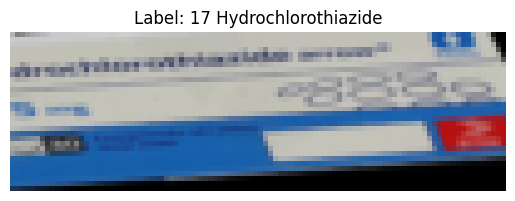

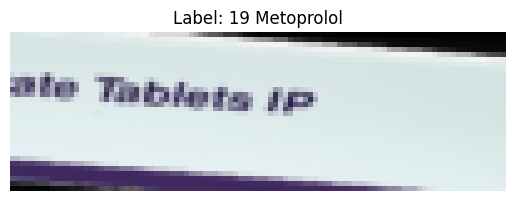

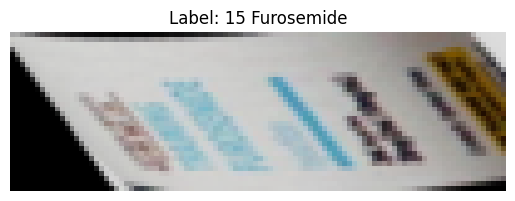

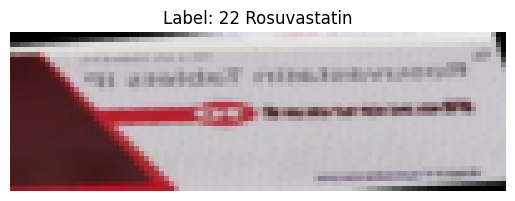

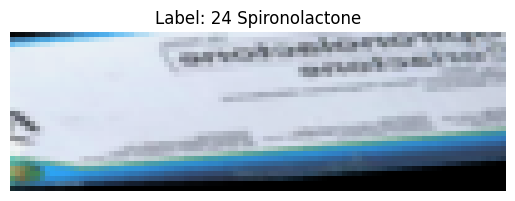

In [22]:

def show_image_with_label(image, label):
    """Display image with its readable label."""
    image = image.numpy().transpose((1, 2, 0))  # Convert (C, H, W) -> (H, W, C)
    image = (image + 1.0) / 2.0  # De-normalize from [-1, 1] to [0, 1]
    image = np.clip(image, 0, 1)  # Clip values to valid range
    plt.imshow(image)
    plt.title(f"Label: {label} {category_id_to_name.get(int(label))}")
    plt.axis("off")
    plt.show()
    
    
images, labels = next(iter(train_loader))
print(labels)
def display_batch(dataloader, num_images=5):
    images, labels = next(iter(dataloader))
    
    for i in range(min(num_images, len(images))):
        show_image_with_label(images[i], labels[i])

display_batch(train_loader, num_images=5)

In [23]:
class_names = [category['name'] for category in coco_data['categories']]
dataset_sizes = len(train_dataset) + len(val_dataset) + len(test_dataset)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(torch.backends.mps.is_available())
# print(torch.backends.mps.is_built())

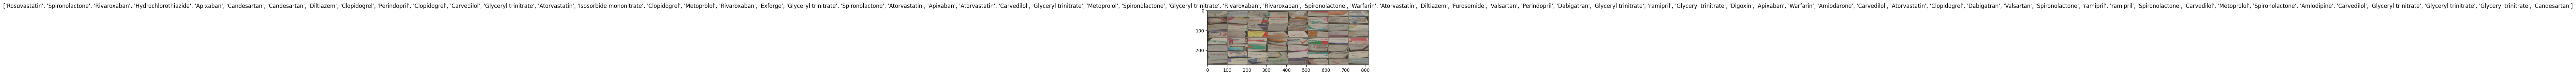

In [24]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [25]:
import time
from tempfile import TemporaryDirectory

def train_model(model, criterion, optimizer, scheduler, num_epochs=25, train_loader=None, val_loader=None):
    since = time.time()
    
    model = model.to(device)
    # Initialize lists to store loss and accuracy for plotting
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Training phase
            model.train()  # Set model to training mode
            running_loss = 0.0
            running_corrects = 0

            # Iterate over training data
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # print(f"inputs device: {inputs.device}, labels device: {labels.device}")

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                loss.backward()
                optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Validation phase
            model.eval()  # Set model to evaluate mode
            val_loss = 0.0
            val_corrects = 0

            with torch.no_grad():  # No gradients needed during validation
                for inputs, labels in val_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Statistics
                    val_loss += loss.item() * inputs.size(0)
                    val_corrects += torch.sum(preds == labels.data)

            # Update learning rate scheduler
            scheduler.step()

            # Calculate losses and accuracies
            train_loss = running_loss / len(train_loader.dataset)
            train_acc = running_corrects.double() / len(train_loader.dataset)

            val_loss = val_loss / len(val_loader.dataset)
            val_acc = val_corrects.double() / len(val_loader.dataset)

            # Append the values for plotting
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            # Print the results
            print(f'Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f}')
            print(f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')

            # Deep copy the model if we have a new best validation accuracy
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), best_model_params_path)

            print()

        # Load the best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

    # Return losses and accuracies to plot
    return model, train_losses, train_accuracies, val_losses, val_accuracies


In [26]:
# Example: when plotting an image from a tensor
def imshow(tensor, title=None):
    """Display image for Tensor."""
    tensor = tensor.cpu().numpy().transpose((1, 2, 0))  # Move tensor to CPU and convert to NumPy
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor = std * tensor + mean
    tensor = np.clip(tensor, 0, 1)
    plt.imshow(tensor)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# In the plotting function for loss and accuracy:
def plot_learning_curves(train_losses, train_accuracies, val_losses, val_accuracies):
    num_epochs = len(train_losses)

    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(num_epochs), val_accuracies, label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Show plots
    plt.tight_layout()
    plt.show()


In [27]:
def visualize_model(model, num_images=6, val_loader=val_loader, class_names=class_names, device=device):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j].item()]}')

                # Call imshow to display the image
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)



In [28]:
## Load pre-trained IMAGENET1K_V1 reset final fully connected layer.

In [29]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Modify the fully connected (fc) layer to add Dropout
model_ft.fc = nn.Sequential(
    nn.Dropout(p=0.5),  # Increase dropout to stabilize validation
    nn.Linear(num_ftrs, 256),  
    nn.ReLU(),
    nn.Linear(256, 30)  # Output layer
)

model_ft = model_ft.to(device)



criterion = nn.CrossEntropyLoss(label_smoothing=0.05)


# Optimizer: Slightly higher weight decay for regularization
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0003, weight_decay=4e-4)

# Learning Rate Scheduler: Increase T_max to smooth learning
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=170)


/Users/baiporthn/.pyenv/versions/3.9.13/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/baiporthn/.pyenv/versions/3.9.13/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
### Train the model




model_ft, train_loss, train_acc, val_loss, val_acc = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100, train_loader=train_loader, val_loader=val_loader
)



In [85]:
train_acc = np.array([t.cpu().numpy() for t in train_acc])
val_acc = np.array([t.cpu().numpy() for t in val_acc])

Mean Train Accuracy: 0.8888540540540539
Mean Val Accuracy: 0.2435114503816794
Mean Train Loss: 0.7343516866932045
Mean Val Loss: 3.6099044905303384


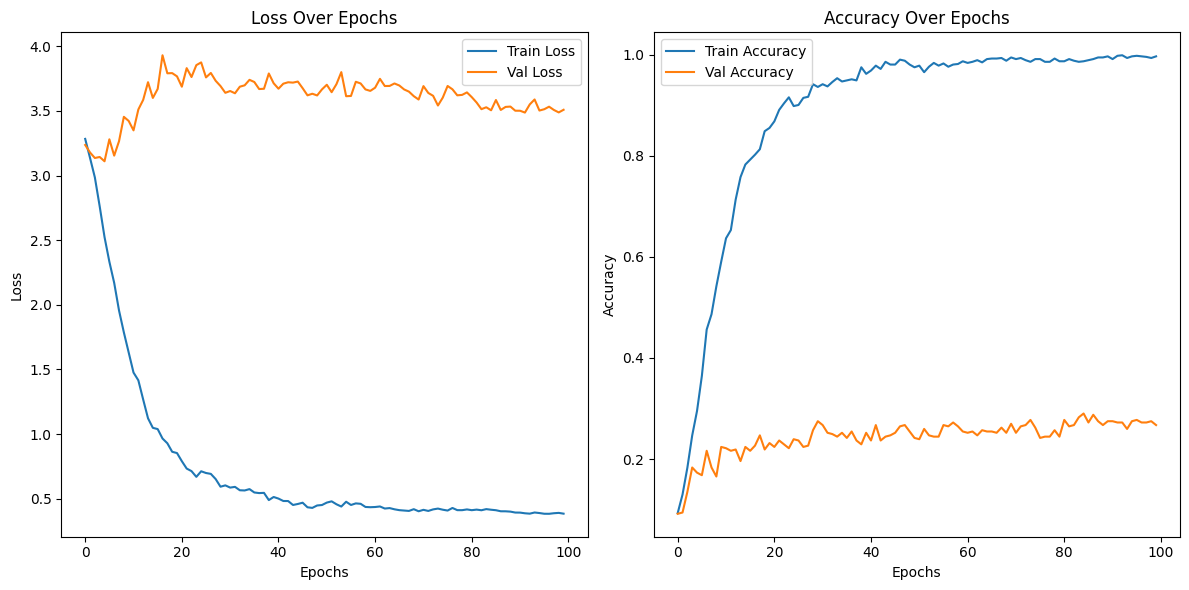

In [86]:
# Plot the learning curves



print(f"Mean Train Accuracy: {np.mean(train_acc)}")
print(f"Mean Val Accuracy: {np.mean(val_acc)}")
print(f"Mean Train Loss: {np.mean(train_loss)}")
print(f"Mean Val Loss: {np.mean(val_loss)}")


plot_learning_curves(train_loss, train_acc, val_loss, val_acc)


In [32]:
#save

import numpy as np

np.save("train_accuracy_29_2.npy", train_acc)
np.save("val_accuracy_29_2.npy", val_acc)
train_acc = np.load("train_accuracy_29_2.npy")
val_acc = np.load("val_accuracy_29_2.npy")
torch.save(model_ft.state_dict(), "resnet50_medicine_classifier_29_2.pt")



In [33]:
#load model
model_ft.load_state_dict(torch.load("resnet50_medicine_classifier_29_2.pt"))
model_ft.eval()

# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming you have all_preds and all_labels
# cm = confusion_matrix(all_labels, all_preds)

# plt.figure(figsize=(12, 10))
# sns.heatmap(cm, annot=False, cmap='Blues', fmt='g')
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.savefig("confusion_matrix.png", dpi=300)
# plt.show()

# sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)


/var/folders/6h/2hwvlr0x1nq1wb31yc7l428c0000gn/T/ipykernel_11385/2302724180.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load("resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#exp2